# Homework 1 - EECS 600 Deep Learning

Name: Roxanne Yang

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you are limited to basic operations within tensorflow and cannot use their high level APIs like tf.optimizer

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 9/24/19 - midnight EST

100 Points Total

In [0]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
tf.enable_eager_execution()

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255. 

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

train_dataset_original = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset_original = tf.data.Dataset.from_tensor_slices((x_test, y_test))

11493376/11490434 [==============================] - 0s 0us/step


## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.

# Question 1
Implement a neural network with one hidden layer with 32 neurons with sigmoid activation functions and a softmax output layer with 10 outputs to classify the loaded MNIST digits as the number they represent. Each training step should be done with a batch size of 64 and the the order of the training samples should be shuffled each epoch. You may use the [tensorflow data API](https://www.tensorflow.org/beta/tutorials/load_data/numpy) to assist with that.

The loss function should me [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) between the prediction and the true results. At the end of each training epoch, the accuracy and loss value should be calculated for the whole training dataset and testing dataset. Use stochastic gradient descent as the training algorithm. Determine an effective learning rate.

In [0]:
# This section defines the 1-hidden-layer neural network model with the option of using ReLU or not (sigmoid if not ReLU), its update rule, etc.
class Model(object):
  def __init__(self, num_hidden=32, num_output=10, num_inputs=784, use_relu=False):
    self.b1 = tf.Variable(tf.random.normal(
                  (1, num_hidden),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b1'))
    self.W1 = tf.Variable(tf.random.normal(
                  (num_inputs, num_hidden),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W1'))
    self.b2 = tf.Variable(tf.random.normal(
                  (1, num_output),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b2'))
    self.W2 = tf.Variable(tf.random.normal(
                  (num_hidden, num_output),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W2'))
    self.use_relu = use_relu
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    if (self.use_relu):
      a1 = tf.nn.relu(
            tf.linalg.matmul(x, self.W1) + self.b1
            )
    else:
      a1 = tf.sigmoid(
            tf.linalg.matmul(x, self.W1) + self.b1
            )
    a2 = tf.nn.softmax(
          tf.linalg.matmul(a1, self.W2) + self.b2
          )
    return a2

def loss(y_hat, y):
  return tf.reduce_mean(tf.square(y_hat - y))

def accuracy(y_hat, y):
  count = 0
  for i in range(y_hat.shape[0]):
    for j in range(y_hat.shape[1]):
      if (y[i,j] > 0.5 and y_hat[i,j] > 0.5):
        count += 1
  tot = float(y_hat.shape.as_list()[0])
  return count/tot


def train_step(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model.W1, model.W2, model.b1, model.b2])
  
  model.W1.assign_sub(learning_rate * dW1)
  model.W2.assign_sub(learning_rate * dW2)
  model.b1.assign_sub(learning_rate * db1)
  model.b2.assign_sub(learning_rate * db2)

In [4]:
# Calls the Model to learn a 1-hidden-layer NN with 32 hidden units and sigmoid activation function
model = Model()
learning_rate = 0.2

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
                         
for epoch in range(10):
  train_dataset = train_dataset_original.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  test_dataset = test_dataset_original.batch(BATCH_SIZE)
  for inputs, outputs in iter(train_dataset):
    train_step(model, inputs, outputs, learning_rate)
    
  train_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(train_dataset)]))
  train_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(train_dataset)]))
  test_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(test_dataset)]))
  test_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(test_dataset)]))

  print(f'The accuracy value and loss value for epoch {epoch} are accuracy: {train_accuracy[-1]: 0.2f}, loss: {train_loss[-1]:0.2f}')
  print(f'The testing accuracy value and loss value for epoch {epoch} are accuracy: {test_accuracy[-1]: 0.2f}, loss: {test_loss[-1]:0.2f}')

The accuracy value and loss value for epoch 0 are accuracy:  0.20, loss: 0.10
The testing accuracy value and loss value for epoch 0 are accuracy:  0.21, loss: 0.10
The accuracy value and loss value for epoch 1 are accuracy:  0.25, loss: 0.09
The testing accuracy value and loss value for epoch 1 are accuracy:  0.27, loss: 0.09
The accuracy value and loss value for epoch 2 are accuracy:  0.29, loss: 0.09
The testing accuracy value and loss value for epoch 2 are accuracy:  0.30, loss: 0.08
The accuracy value and loss value for epoch 3 are accuracy:  0.32, loss: 0.08
The testing accuracy value and loss value for epoch 3 are accuracy:  0.34, loss: 0.08
The accuracy value and loss value for epoch 4 are accuracy:  0.35, loss: 0.08
The testing accuracy value and loss value for epoch 4 are accuracy:  0.37, loss: 0.07
The accuracy value and loss value for epoch 5 are accuracy:  0.38, loss: 0.07
The testing accuracy value and loss value for epoch 5 are accuracy:  0.40, loss: 0.07
The accuracy val

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)

In [0]:
def plot_loss_and_accuracy(n, train_accuracy, test_accuracy, train_loss, test_loss):
  xxx = np.arange(0, n, 1)
  plt.plot(xxx, train_accuracy)
  plt.plot(xxx, test_accuracy)
  plt.legend(['Train', 'Test'])

  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

  plt.figure()

  plt.plot(xxx, train_loss)
  plt.plot(xxx, test_loss)
  plt.legend(['Train', 'Test'])

  plt.xlabel("Epoch")
  plt.ylabel("Loss")

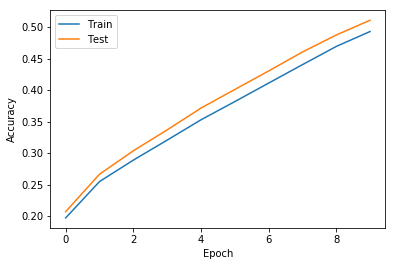

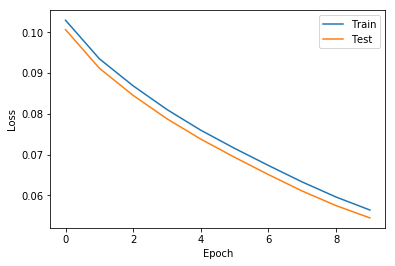

In [6]:
plot_loss_and_accuracy(10, train_accuracy, test_accuracy, train_loss, test_loss)

## Question 1 Part 2
Change the size of your hidden layer to 16 neurons and re-run the training.

In [7]:
# Calls the Model to learn a 1-hidden-layer NN with 16 hidden units and sigmoid activation function
model = Model(num_hidden=16)
learning_rate = 0.2

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
                         
for epoch in range(10):
  train_dataset = train_dataset_original.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  test_dataset = test_dataset_original.batch(BATCH_SIZE)
  for inputs, outputs in iter(train_dataset):
    train_step(model, inputs, outputs, learning_rate)
    
  train_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(train_dataset)]))
  train_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(train_dataset)]))
  test_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(test_dataset)]))
  test_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(test_dataset)]))
  
  print(f'The accuracy value and loss value for epoch {epoch} are accuracy: {train_accuracy[-1]: 0.2f}, loss: {train_loss[-1]:0.2f}')
  print(f'The testing accuracy value and loss value for epoch {epoch} are accuracy: {test_accuracy[-1]: 0.2f}, loss: {test_loss[-1]:0.2f}')

The accuracy value and loss value for epoch 0 are accuracy:  0.05, loss: 0.10
The testing accuracy value and loss value for epoch 0 are accuracy:  0.05, loss: 0.10
The accuracy value and loss value for epoch 1 are accuracy:  0.08, loss: 0.09
The testing accuracy value and loss value for epoch 1 are accuracy:  0.08, loss: 0.09
The accuracy value and loss value for epoch 2 are accuracy:  0.12, loss: 0.09
The testing accuracy value and loss value for epoch 2 are accuracy:  0.12, loss: 0.09
The accuracy value and loss value for epoch 3 are accuracy:  0.15, loss: 0.08
The testing accuracy value and loss value for epoch 3 are accuracy:  0.14, loss: 0.08
The accuracy value and loss value for epoch 4 are accuracy:  0.16, loss: 0.08
The testing accuracy value and loss value for epoch 4 are accuracy:  0.16, loss: 0.08
The accuracy value and loss value for epoch 5 are accuracy:  0.18, loss: 0.08
The testing accuracy value and loss value for epoch 5 are accuracy:  0.17, loss: 0.08
The accuracy val

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)



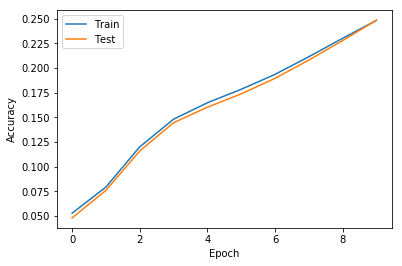

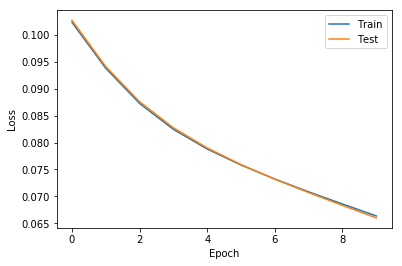

In [8]:
plot_loss_and_accuracy(10, train_accuracy, test_accuracy, train_loss, test_loss)

##Question 1 Part 3
Change your network architecture to have two hidden layers each of size 16 and re-run the training

In [0]:
# This section defines the 2-hidden-layer neural network model, its update rule, etc.
class Model2(object):
  def __init__(self, num_hidden_1=16, num_hidden_2=16, num_output=10, num_inputs=784):
    self.b1 = tf.Variable(tf.random.normal(
                  (1, num_hidden_1),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b1'))
    self.W1 = tf.Variable(tf.random.normal(
                  (num_inputs, num_hidden_1),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W1'))
    self.b2 = tf.Variable(tf.random.normal(
                  (1, num_hidden_2),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b2'))
    self.W2 = tf.Variable(tf.random.normal(
                  (num_hidden_1, num_hidden_2),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W2'))
    self.b3 = tf.Variable(tf.random.normal(
                  (1, num_output),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b3'))
    self.W3 = tf.Variable(tf.random.normal(
                  (num_hidden_2, num_output),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W3'))
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    a1 = tf.sigmoid(
          tf.linalg.matmul(x, self.W1) + self.b1
          )
    a2 = tf.sigmoid(
          tf.linalg.matmul(a1, self.W2) + self.b2
          )
    a3 = tf.nn.softmax(
          tf.linalg.matmul(a2, self.W3) + self.b3
          )
    return a3

def train_step_2(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, dW3, db1, db2, db3 = t.gradient(current_loss, [model.W1, model.W2, model.W3, model.b1, model.b2, model.b3])
  
  model.W1.assign_sub(learning_rate * dW1)
  model.W2.assign_sub(learning_rate * dW2)
  model.W3.assign_sub(learning_rate * dW3)
  model.b1.assign_sub(learning_rate * db1)
  model.b2.assign_sub(learning_rate * db2)
  model.b3.assign_sub(learning_rate * db3)

In [10]:
# Calls the Model to learn a 2-hidden-layer NN with 16 hidden units per layer and sigmoid activation function
model = Model2()
learning_rate = 0.2

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
                         
for epoch in range(10):
  train_dataset = train_dataset_original.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  test_dataset = test_dataset_original.batch(BATCH_SIZE)
  for inputs, outputs in iter(train_dataset):
    train_step_2(model, inputs, outputs, learning_rate)
    
  train_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(train_dataset)]))
  train_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(train_dataset)]))
  test_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(test_dataset)]))
  test_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(test_dataset)]))
  
  print(f'The accuracy value and loss value for epoch {epoch} are accuracy: {train_accuracy[-1]: 0.2f}, loss: {train_loss[-1]:0.2f}')
  print(f'The testing accuracy value and loss value for epoch {epoch} are accuracy: {test_accuracy[-1]: 0.2f}, loss: {test_loss[-1]:0.2f}')

The accuracy value and loss value for epoch 0 are accuracy:  0.00, loss: 0.10
The testing accuracy value and loss value for epoch 0 are accuracy:  0.00, loss: 0.10
The accuracy value and loss value for epoch 1 are accuracy:  0.00, loss: 0.10
The testing accuracy value and loss value for epoch 1 are accuracy:  0.00, loss: 0.10
The accuracy value and loss value for epoch 2 are accuracy:  0.00, loss: 0.09
The testing accuracy value and loss value for epoch 2 are accuracy:  0.00, loss: 0.09
The accuracy value and loss value for epoch 3 are accuracy:  0.00, loss: 0.09
The testing accuracy value and loss value for epoch 3 are accuracy:  0.00, loss: 0.09
The accuracy value and loss value for epoch 4 are accuracy:  0.00, loss: 0.09
The testing accuracy value and loss value for epoch 4 are accuracy:  0.00, loss: 0.09
The accuracy value and loss value for epoch 5 are accuracy:  0.00, loss: 0.09
The testing accuracy value and loss value for epoch 5 are accuracy:  0.00, loss: 0.09
The accuracy val

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)
![alt text](https://)

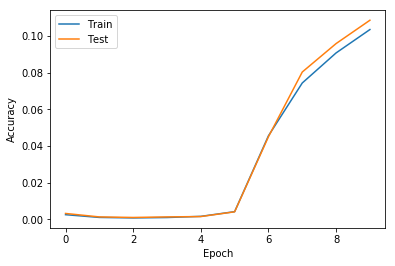

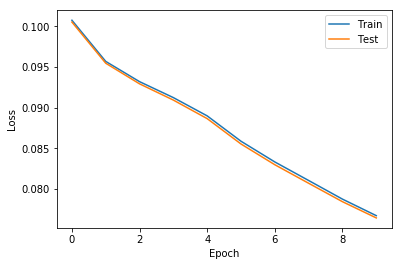

In [11]:
plot_loss_and_accuracy(10, train_accuracy, test_accuracy, train_loss, test_loss)

## Question 1 Part 4
Change the activation functions in the hidden layer to ReLU and re-run the training

In [12]:
# Calls the Model to learn a 1-hidden-layer NN with 32 hidden units and ReLu activation function
model = Model(use_relu=True)
learning_rate = 0.2

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
                         
for epoch in range(10):
  train_dataset = train_dataset_original.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  test_dataset = test_dataset_original.batch(BATCH_SIZE)
  for inputs, outputs in iter(train_dataset):
    train_step(model, inputs, outputs, learning_rate)
    
  train_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(train_dataset)]))
  train_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(train_dataset)]))
  test_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(test_dataset)]))
  test_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(test_dataset)]))

  print(f'The accuracy value and loss value for epoch {epoch} are accuracy: {train_accuracy[-1]: 0.2f}, loss: {train_loss[-1]:0.2f}')
  print(f'The testing accuracy value and loss value for epoch {epoch} are accuracy: {test_accuracy[-1]: 0.2f}, loss: {test_loss[-1]:0.2f}')

The accuracy value and loss value for epoch 0 are accuracy:  0.18, loss: 0.16
The testing accuracy value and loss value for epoch 0 are accuracy:  0.18, loss: 0.16
The accuracy value and loss value for epoch 1 are accuracy:  0.19, loss: 0.16
The testing accuracy value and loss value for epoch 1 are accuracy:  0.20, loss: 0.16
The accuracy value and loss value for epoch 2 are accuracy:  0.23, loss: 0.15
The testing accuracy value and loss value for epoch 2 are accuracy:  0.23, loss: 0.15
The accuracy value and loss value for epoch 3 are accuracy:  0.28, loss: 0.14
The testing accuracy value and loss value for epoch 3 are accuracy:  0.28, loss: 0.14
The accuracy value and loss value for epoch 4 are accuracy:  0.31, loss: 0.13
The testing accuracy value and loss value for epoch 4 are accuracy:  0.32, loss: 0.13
The accuracy value and loss value for epoch 5 are accuracy:  0.34, loss: 0.13
The testing accuracy value and loss value for epoch 5 are accuracy:  0.35, loss: 0.13
The accuracy val

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


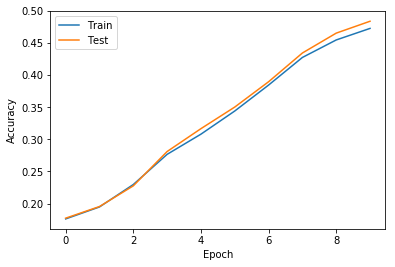

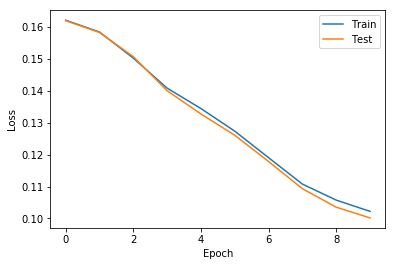

In [13]:
plot_loss_and_accuracy(10, train_accuracy, test_accuracy, train_loss, test_loss)

## Question 1 part 5
Describe how changing the size of the hidden layer and the number of hidden layers impacted the predictions of the network.

**Hidden Layer Size:** With the same number of epochs and the same learning rate, the bigger a hidden layer gets, the more accurate the output model is. This is because when there are less hidden units in the layer, the input information gets really compressed and a lot of information (potentially useful) gets lost.

**Hidden Layer Number:** With the same number of hidden units per layer, same number of epochs and the same learning rate, increasing the number of hidden layers decrases the accuracy and increases the loss of the model. This is probably because more layers increase the capacity of the neural network representation, and it would need more epochs to be able to learn the same concept.

# Question 2 Part 1

Re-use the network built above but modify the update step to the following.

\begin{align}
V_t = \beta V_{t-1} + (1-\beta)g_t \\
W_{t+1} = W_t - \alpha V_t
\end{align}

where $V_t$ is the update vector for step $t$. Use $\beta=0.1$.

In [0]:
# This section defines the 1-hidden-layer neural network model with momentum, its update rule, etc.
class Model_with_momentum(object):
  def __init__(self, num_hidden=32, num_output=10, num_inputs=784, beta=0.1):
    self.b1 = tf.Variable(tf.random.normal(
                  (1, num_hidden),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b1'))
    self.W1 = tf.Variable(tf.random.normal(
                  (num_inputs, num_hidden),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W1'))
    self.b2 = tf.Variable(tf.random.normal(
                  (1, num_output),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b2'))
    self.W2 = tf.Variable(tf.random.normal(
                  (num_hidden, num_output),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W2'))
    self.beta = beta
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    a1 = tf.sigmoid(
          tf.linalg.matmul(x, self.W1) + self.b1
          )
    a2 = tf.nn.softmax(
          tf.linalg.matmul(a1, self.W2) + self.b2
          )
    return a2

def train_step_momentum(model, inputs, outputs, learning_rate, pdW1, pdW2, pdb1, pdb2):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model.W1, model.W2, model.b1, model.b2])
  
  model.W1.assign_sub(learning_rate * (dW1 * (1 - model.beta) + pdW1 * model.beta))
  model.W2.assign_sub(learning_rate * (dW2 * (1 - model.beta) + pdW2 * model.beta))
  model.b1.assign_sub(learning_rate * (db1 * (1 - model.beta) + pdb1 * model.beta))
  model.b2.assign_sub(learning_rate * (db2 * (1 - model.beta) + pdb2 * model.beta))
  
  return dW1, dW2, db1, db2

In [15]:
# Calls the Model to learn a 1-hidden-layer NN with 32 hidden units and sigmoid function, with momentum beta = 0.1
model = Model_with_momentum()
learning_rate = 0.2

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
                         
for epoch in range(10):
  train_dataset = train_dataset_original.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  test_dataset = test_dataset_original.batch(BATCH_SIZE)
  dW1, dW2, db1, db2 = 0, 0, 0, 0
  for inputs, outputs in iter(train_dataset):
    dW1, dW2, db1, db2 = train_step_momentum(model, inputs, outputs, learning_rate, dW1, dW2, db1, db2)
    
  train_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(train_dataset)]))
  train_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(train_dataset)]))
  test_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(test_dataset)]))
  test_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(test_dataset)]))

  print(f'The accuracy value and loss value for epoch {epoch} are accuracy: {train_accuracy[-1]: 0.2f}, loss: {train_loss[-1]:0.2f}')
  print(f'The testing accuracy value and loss value for epoch {epoch} are accuracy: {test_accuracy[-1]: 0.2f}, loss: {test_loss[-1]:0.2f}')

The accuracy value and loss value for epoch 0 are accuracy:  0.11, loss: 0.11
The testing accuracy value and loss value for epoch 0 are accuracy:  0.11, loss: 0.11
The accuracy value and loss value for epoch 1 are accuracy:  0.15, loss: 0.10
The testing accuracy value and loss value for epoch 1 are accuracy:  0.15, loss: 0.10
The accuracy value and loss value for epoch 2 are accuracy:  0.20, loss: 0.09
The testing accuracy value and loss value for epoch 2 are accuracy:  0.20, loss: 0.09
The accuracy value and loss value for epoch 3 are accuracy:  0.25, loss: 0.08
The testing accuracy value and loss value for epoch 3 are accuracy:  0.25, loss: 0.08
The accuracy value and loss value for epoch 4 are accuracy:  0.30, loss: 0.07
The testing accuracy value and loss value for epoch 4 are accuracy:  0.30, loss: 0.07
The accuracy value and loss value for epoch 5 are accuracy:  0.34, loss: 0.07
The testing accuracy value and loss value for epoch 5 are accuracy:  0.34, loss: 0.07
The accuracy val

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


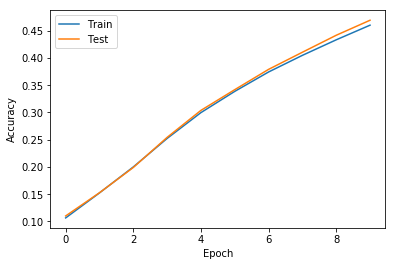

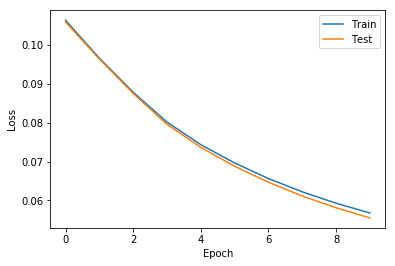

In [16]:
plot_loss_and_accuracy(10, train_accuracy, test_accuracy, train_loss, test_loss)

## Question 2 part 2
Re-run the training with $\beta=0.9$

In [17]:
# Calls the Model to learn a 1-hidden-layer NN with 32 hidden units and sigmoid function, with momentum beta = 0.9
model = Model_with_momentum(beta=0.9)
learning_rate = 0.2

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
                         
for epoch in range(10):
  train_dataset = train_dataset_original.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  test_dataset = test_dataset_original.batch(BATCH_SIZE)
  dW1, dW2, db1, db2 = 0, 0, 0, 0
  for inputs, outputs in iter(train_dataset):
    dW1, dW2, db1, db2 = train_step_momentum(model, inputs, outputs, learning_rate, dW1, dW2, db1, db2)
    
  train_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(train_dataset)]))
  train_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(train_dataset)]))
  test_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(test_dataset)]))
  test_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(test_dataset)]))

  print(f'The accuracy value and loss value for epoch {epoch} are accuracy: {train_accuracy[-1]: 0.2f}, loss: {train_loss[-1]:0.2f}')
  print(f'The testing accuracy value and loss value for epoch {epoch} are accuracy: {test_accuracy[-1]: 0.2f}, loss: {test_loss[-1]:0.2f}')

The accuracy value and loss value for epoch 0 are accuracy:  0.14, loss: 0.11
The testing accuracy value and loss value for epoch 0 are accuracy:  0.15, loss: 0.11
The accuracy value and loss value for epoch 1 are accuracy:  0.19, loss: 0.10
The testing accuracy value and loss value for epoch 1 are accuracy:  0.20, loss: 0.10
The accuracy value and loss value for epoch 2 are accuracy:  0.23, loss: 0.10
The testing accuracy value and loss value for epoch 2 are accuracy:  0.24, loss: 0.09
The accuracy value and loss value for epoch 3 are accuracy:  0.26, loss: 0.09
The testing accuracy value and loss value for epoch 3 are accuracy:  0.27, loss: 0.09
The accuracy value and loss value for epoch 4 are accuracy:  0.29, loss: 0.08
The testing accuracy value and loss value for epoch 4 are accuracy:  0.30, loss: 0.08
The accuracy value and loss value for epoch 5 are accuracy:  0.33, loss: 0.08
The testing accuracy value and loss value for epoch 5 are accuracy:  0.34, loss: 0.08
The accuracy val

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


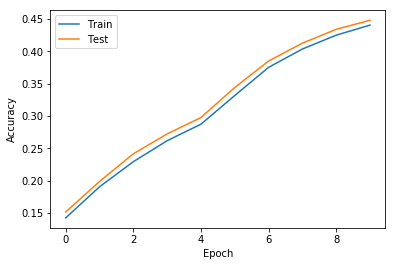

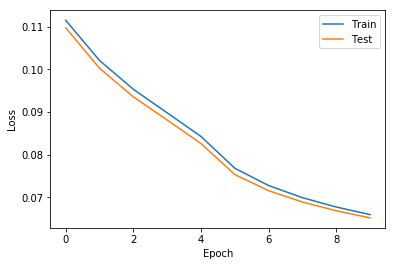

In [18]:
plot_loss_and_accuracy(10, train_accuracy, test_accuracy, train_loss, test_loss)

## Question 2 Part 3
Describe the differences in training results comparing the different values of $\beta$.

With the same learning rate and epoch number, the lower beta value (0.1) had better performance. This is likely because with a lower beta value, the model is able to learn faster. With a higher beta value, the model takes a "safer" way, in the sense that it's more likely to get out of local maxima, but it learns slower.

I initially imagined that the higher beta value (0.9) produced a closer relation between training set and testing set, but that doesn't seem to be the case.

## Question 2 Part 4
Re-use the network above, but implement the [AdaDelta](http://ruder.io/optimizing-gradient-descent/index.html#adadelta) learning algorithm. You can assume an initial value of $RMS[\nabla \theta]_{t-1} = 1.0$

In [0]:
# This section defines the 1-hidden-layer neural network model with AdaDelta Optimization, its update rule, etc.
class Model_with_AdaDelta(object):
  def __init__(self, num_hidden=32, num_output=10, num_inputs=784):
    self.b1 = tf.Variable(tf.random.normal(
                  (1, num_hidden),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b1'))
    self.W1 = tf.Variable(tf.random.normal(
                  (num_inputs, num_hidden),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W1'))
    self.b2 = tf.Variable(tf.random.normal(
                  (1, num_output),
                  mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='b2'))
    self.W2 = tf.Variable(tf.random.normal(
                  (num_hidden, num_output),
                   mean=0.0,
                  stddev=1.0,
                  dtype=tf.dtypes.float32,
                  seed=None,
                  name='W2'))
    
  def __call__(self, x):
    return self.forward(x)

  def forward(self, x):
    a1 = tf.sigmoid(
          tf.linalg.matmul(x, self.W1) + self.b1
          )
    a2 = tf.nn.softmax(
          tf.linalg.matmul(a1, self.W2) + self.b2
          )
    return a2

def train_step_AdaDelta(model, inputs, outputs, learning_rate, prms_1=1, prms_2=1):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
    dW1, dW2, db1, db2 = t.gradient(current_loss, [model.W1, model.W2, model.b1, model.b2])

  # learning rate = RMS(update) t - 1 / RMS(gradient) 
  learning_rate_1 = prms_1 / rms(dW1)
  learning_rate_2 = prms_2 / rms(dW2)

  model.W1.assign_sub(learning_rate * dW1)
  model.W2.assign_sub(learning_rate * dW2)
  model.b1.assign_sub(learning_rate * db1)
  model.b2.assign_sub(learning_rate * db2)

  return learning_rate_1 * dW1, learning_rate_2 * dW2, learning_rate_1 * db1, learning_rate_2 * db2

def rms(y):
  output = np.sqrt(np.mean(y**2))
  if output == 0:
    return 0.0000000001
  return output

In [20]:
# Calls the Model to learn a 1-hidden-layer NN with 32 hidden units and AdaDelta optimization
model = Model_with_AdaDelta()

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []

first = True
dW1, dW2 = 1, 1            
for epoch in range(10):
  train_dataset = train_dataset_original.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  test_dataset = test_dataset_original.batch(BATCH_SIZE)
  for inputs, outputs in iter(train_dataset):
    prms_1, prms_2 = 1, 1
    if (first):
      prms_1 = 1
      prms_2 = 1
    else:
      prms_1 = rms(dW1)
      prms_2 = rms(dW2)
    first = False
    dW1, dW2, db1, db2 = train_step_AdaDelta(model, inputs, outputs, prms_1, prms_2)
    
  train_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(train_dataset)]))
  train_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(train_dataset)]))
  test_loss.append(tf.reduce_mean([loss(model(x), y) for x, y in iter(test_dataset)]))
  test_accuracy.append(tf.reduce_mean([accuracy(model(x), y) for x, y in iter(test_dataset)]))

  print(f'The accuracy value and loss value for epoch {epoch} are accuracy: {train_accuracy[-1]: 0.2f}, loss: {train_loss[-1]:0.2f}')
  print(f'The testing accuracy value and loss value for epoch {epoch} are accuracy: {test_accuracy[-1]: 0.2f}, loss: {test_loss[-1]:0.2f}')

The accuracy value and loss value for epoch 0 are accuracy:  0.35, loss: 0.08
The testing accuracy value and loss value for epoch 0 are accuracy:  0.36, loss: 0.07
The accuracy value and loss value for epoch 1 are accuracy:  0.46, loss: 0.06
The testing accuracy value and loss value for epoch 1 are accuracy:  0.48, loss: 0.06
The accuracy value and loss value for epoch 2 are accuracy:  0.57, loss: 0.05
The testing accuracy value and loss value for epoch 2 are accuracy:  0.59, loss: 0.05
The accuracy value and loss value for epoch 3 are accuracy:  0.66, loss: 0.04
The testing accuracy value and loss value for epoch 3 are accuracy:  0.67, loss: 0.04
The accuracy value and loss value for epoch 4 are accuracy:  0.72, loss: 0.03
The testing accuracy value and loss value for epoch 4 are accuracy:  0.73, loss: 0.03
The accuracy value and loss value for epoch 5 are accuracy:  0.75, loss: 0.03
The testing accuracy value and loss value for epoch 5 are accuracy:  0.76, loss: 0.03
The accuracy val

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


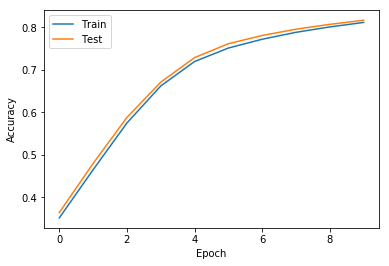

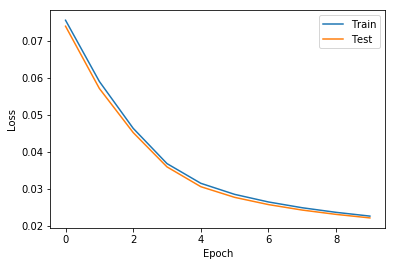

In [21]:
plot_loss_and_accuracy(10, train_accuracy, test_accuracy, train_loss, test_loss)